# Time Series Anomaly Detection


## Problem Statement

There are periods of time where yahoo expects higher than normal network traffic. One example of such a period of high network traffic is during March Madness when users of their services are constantly checking their performance on the fantasy leagues. This kind of anomaly is expected. The challenge for Yahoo is being able to distinguish between the expected anomalies and those that aren’t. Yahoo Webscope data sharing program provides a dataset that can be used to test and validate anomaly detection algorithms.

## Data Selection

**Announcing A Benchmark Dataset for Time Series Anomaly Detection**

https://research.yahoo.com/news/announcing-benchmark-dataset-time-series-anomaly-detection

These Webscope Datasets available from Yahoo! Labs requires one to request access to download it. Approval could take up to a week.

We will chose 1 of 4 available datasets, in which the data is labeled.  The data is highly unbalanced, with anomalies representing 0.56% of the data.

### Description

The Webscope Dataset we used contained 100 csv files with a total of 169680 rows of time series data. In this dataset there are 8 predictors and 1 target column. All of the predictors are numerical. Using this dataset we intend to build time series models that can identify anomalies.

## Data Preprocessing & Summary

We used **`python`** and **`R`** to analyze the dataset. 

### Loading the data using R

In [ ]:
setwd("data")

In [6]:
file_list <- list.files(".")
if (exists("dataset")){
  rm(dataset)
}
for (file in file_list){
  
  # if the merged dataset doesn't exist, create it
  if (!exists("dataset")){
    dataset <- read.csv(file, header=TRUE, sep=",")
  }
  
  # if the merged dataset does exist, append to it
  if (exists("dataset")){
    temp_dataset <-read.csv(file, header=TRUE, sep=",")
    dataset<-rbind(dataset, temp_dataset)
    rm(temp_dataset)
  }
  
}

### Summary

In [7]:
summary(dataset)
cat('Number of rows is ',nrow(dataset))

   timestamps            value             anomaly          changepoint
 Min.   :1.417e+09   Min.   :-7987.86   Min.   :0.000000   Min.   :0   
 1st Qu.:1.418e+09   1st Qu.: -977.93   1st Qu.:0.000000   1st Qu.:0   
 Median :1.420e+09   Median :   23.94   Median :0.000000   Median :0   
 Mean   :1.420e+09   Mean   :  -58.89   Mean   :0.005616   Mean   :0   
 3rd Qu.:1.421e+09   3rd Qu.:  947.70   3rd Qu.:0.000000   3rd Qu.:0   
 Max.   :1.423e+09   Max.   : 7006.21   Max.   :1.000000   Max.   :0   
     trend              noise            seasonality1     seasonality2   
 Min.   :-5040.00   Min.   :-877.8337   Min.   :-955.0   Min.   :-920.0  
 1st Qu.: -858.00   1st Qu.: -23.8288   1st Qu.:-233.7   1st Qu.:-151.7  
 Median :    0.00   Median :   0.0142   Median :   0.0   Median :   0.0  
 Mean   :  -58.25   Mean   :  -0.1996   Mean   :   0.0   Mean   :   0.0  
 3rd Qu.:  853.00   3rd Qu.:  23.6788   3rd Qu.: 233.7   3rd Qu.: 151.7  
 Max.   : 5040.00   Max.   : 961.3856   Max.   : 955

Number of rows is  169680

From the output above it can be observed that our dataset contains 169680 rows of data. Additional summary statistics have also been included. It can be observed that the predictors will require standardization because they are not all on the same scale


In [9]:
head(dataset)

timestamps,value,anomaly,changepoint,trend,noise,seasonality1,seasonality2,seasonality3
1416722400,6.470061,0,0,0,6.470061,0.0000,0.00000,0.000000
1416726000,80.972293,0,0,0,-11.077853,67.6000,22.20667,2.243472
1416729600,159.014680,0,0,0,-5.455761,117.0866,42.90000,4.483806
1416733200,214.721803,0,0,0,12.134172,135.2000,60.66976,6.717869
1416736800,201.695834,0,0,0,1.361684,117.0866,74.30498,8.942536
1416740400,172.005843,0,0,0,10.374710,67.6000,82.87644,11.154696


>**snippet of the time series data**

### Missing Data

It is important to check for missing data prior to building the model. To impute missing data we will use the MICE package



 Variables sorted by number of missings: 
     Variable Count
   timestamps     0
        value     0
  changepoint     0
        trend     0
        noise     0
 seasonality1     0
 seasonality2     0
 seasonality3     0


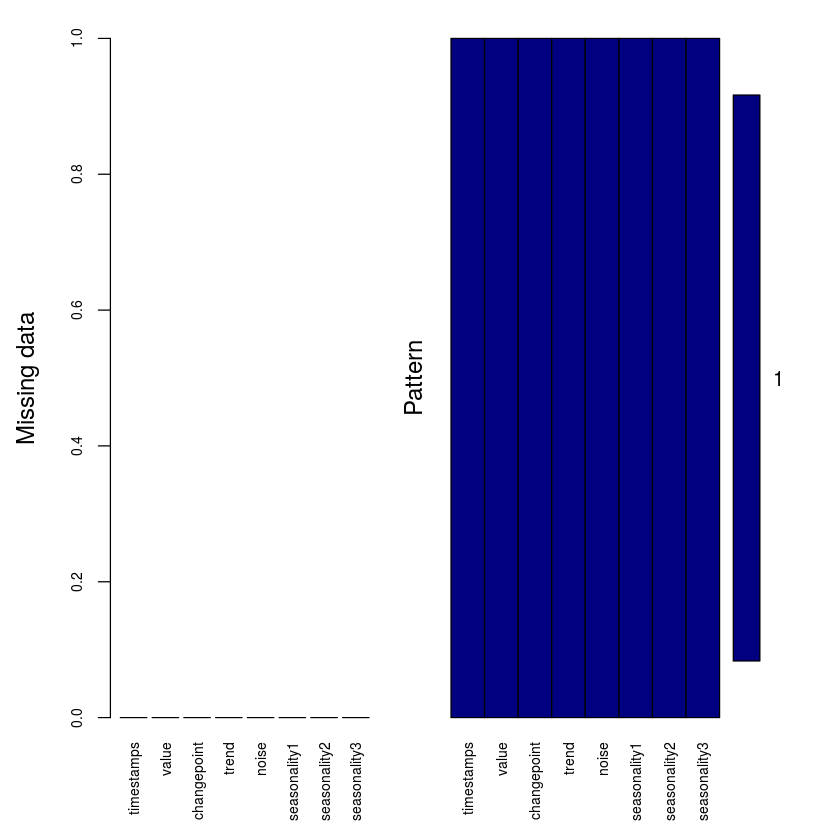

In [36]:
library(mice)
library(VIM)
mice_plot <- aggr(dataset, col=c('navyblue','yellow'),
                    numbers=TRUE, sortVars=TRUE,
                    labels=names(dataset), cex.axis=.7,
                    gap=3, ylab=c("Missing data","Pattern"))

As indicated above our dataset has no missing values.

### **Transformations**

The summary statistics above indicated that our predictors were not on the same scale. Standardizing them would make our models easier to interpret and also save time on building the models. 

To do this, we first begin by saving the `anomaly` column into a variable `y` and remove it from the `dataset` dataframe

In [16]:
y <- dataset[,3]
x <- dataset[,-3]
cat('Y')
head(y)
cat ('X')
head(dataset)

Y

[1] 0 0 0 0 0 0

X

timestamps,value,changepoint,trend,noise,seasonality1,seasonality2,seasonality3
1416722400,6.470061,0,0,6.470061,0.0000,0.00000,0.000000
1416726000,80.972293,0,0,-11.077853,67.6000,22.20667,2.243472
1416729600,159.014680,0,0,-5.455761,117.0866,42.90000,4.483806
1416733200,214.721803,0,0,12.134172,135.2000,60.66976,6.717869
1416736800,201.695834,0,0,1.361684,117.0866,74.30498,8.942536
1416740400,172.005843,0,0,10.374710,67.6000,82.87644,11.154696


>**snippet of the `dataset` dataframe after removing the target cariable `anomaly`**

#### Skewness

We also check for skewness in the data using the `e1071` package which calculates the sample `skewness statistic` for each predictor.

In [19]:
library(e1071)
skewValues <- apply(x, 2, skewness)
head(skewValues)

timestamps         value         trend         noise  seasonality1 
 0.000000e+00 -1.697313e-01 -1.638966e-01  2.529307e-02  6.633139e-16 
 seasonality2 
 1.656920e-16

Asses shape of distribution

value,trend,noise,seasonality1,seasonality2,seasonality3
6.470061,0,6.470061,0.0000,0.00000,0.000000
80.972293,0,-11.077853,67.6000,22.20667,2.243472
159.014680,0,-5.455761,117.0866,42.90000,4.483806
214.721803,0,12.134172,135.2000,60.66976,6.717869
201.695834,0,1.361684,117.0866,74.30498,8.942536
172.005843,0,10.374710,67.6000,82.87644,11.154696


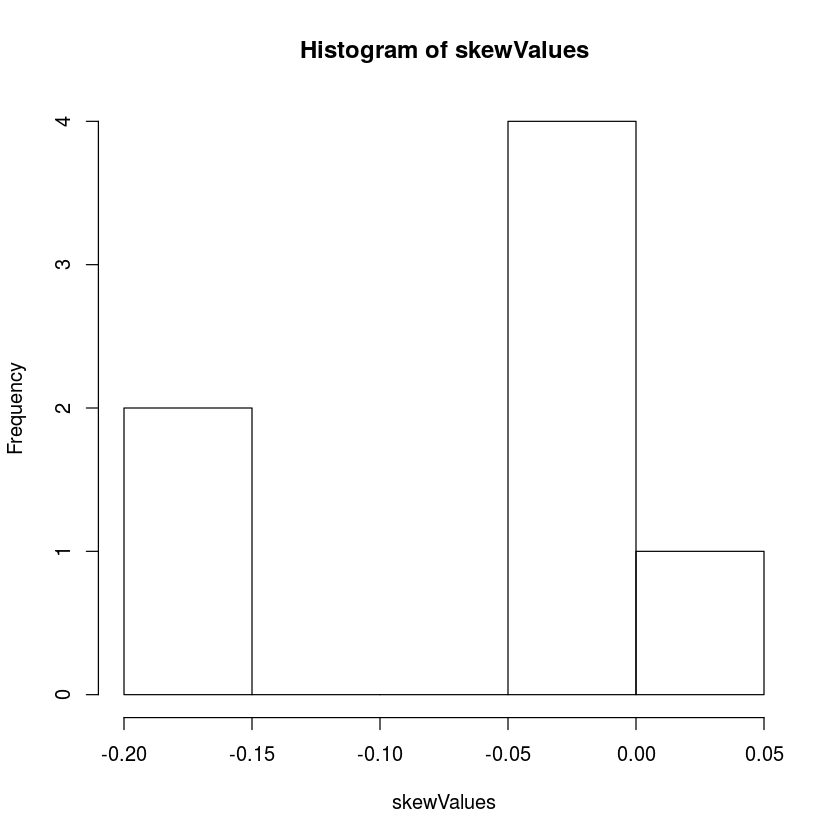

In [26]:
hist(skewValues)
head(x[,-1])

We consider the data to be extremely skewed if the ratio of the highest value to the lowest is greater than 20

In [25]:
ratio <- skewValues["noise"]/skewValues["seasonality2"]
cat("Ratio of highest to lowest skew value",ratio)

Ratio of highest to lowest skew value 1.526511e+14

A value of 1.526511e+14 indicates that our data has extreme skewness. This is also indicated in the histogram above. As a result we need to standardize our data.

#### BoxCox transformation

To standardize our data we use the `caret` function `preProcess` which applies transformations to a set of predictors.

We will exclude the `timestamp` from this transformation

In [28]:
library(caret)
trans <- preProcess(x[,-1],
                    method = c("BoxCox", "center", "scale"))
trans

Loading required package: lattice
Loading required package: ggplot2


Created from 169680 samples and 6 variables

Pre-processing:
  - centered (6)
  - ignored (0)
  - scaled (6)


#### **apply transformations**

In [37]:
x_trans <- predict(trans, x)
head(x_trans)

Warning message in is.na(lam):
“is.na() applied to non-(list or vector) of type 'NULL'”

timestamps,value,trend,noise,seasonality1,seasonality2,seasonality3
1416722400,0.03407135,0.03150748,0.07685769,2.501110e-16,-4.501564e-18,7.797788e-17
1416726000,0.07290769,0.03150748,-0.12535642,1.881166e-01,7.961877e-02,1.166703e-02
1416729600,0.11358943,0.03150748,-0.06057001,3.258275e-01,1.538116e-01,2.331775e-02
1416733200,0.14262830,0.03150748,0.14212831,3.762332e-01,2.175225e-01,3.493585e-02
1416736800,0.13583816,0.03150748,0.01799110,3.258275e-01,2.664096e-01,4.650509e-02
1416740400,0.12036143,0.03150748,0.12185308,1.881166e-01,2.971413e-01,5.800929e-02


### Filtering

To filter near-zero variance predictors, the `caret` package function `nearZeroVar` will return the column numbers of any predictors that don't explain the variance in the data.

When a vector should be removed, a vector of integers is returned that indicates which columns should be removed

In [38]:
nearZeroVar(x_trans)

[1] 3

We now remove the `trend` predictor because it has a near-zero variance. This predictor unlikely to improve our predictive accuracy

In [40]:
x_trans <- x_trans[,-3]
head(x_trans)

timestamps,value,noise,seasonality1,seasonality2,seasonality3
1416722400,0.03407135,0.07685769,2.501110e-16,-4.501564e-18,7.797788e-17
1416726000,0.07290769,-0.12535642,1.881166e-01,7.961877e-02,1.166703e-02
1416729600,0.11358943,-0.06057001,3.258275e-01,1.538116e-01,2.331775e-02
1416733200,0.14262830,0.14212831,3.762332e-01,2.175225e-01,3.493585e-02
1416736800,0.13583816,0.01799110,3.258275e-01,2.664096e-01,4.650509e-02
1416740400,0.12036143,0.12185308,1.881166e-01,2.971413e-01,5.800929e-02


### Correlation

Correlated predictors do not add any extra knowledge to our model. In order to simplify our model we need to remove the correlated predictors. The `cor` function can calculate the correlations between predictor variables. To visualize the correlation data structure we use `corrplot` package

,timestamps,value,noise,seasonality1,seasonality2,seasonality3
timestamps,1.000000000,-0.02594959,-0.0018780573,-4.697417e-03,-9.264234e-03,-6.299239e-02
value,-0.025949589,1.00000000,0.0461569071,1.877230e-01,1.457534e-01,1.021793e-01
noise,-0.001878057,0.04615691,1.0000000000,4.110017e-03,9.919681e-04,1.417808e-03
seasonality1,-0.004697417,0.18772303,0.0041100167,1.000000e+00,2.041722e-16,1.047899e-15
seasonality2,-0.009264234,0.14575345,0.0009919681,2.041722e-16,1.000000e+00,6.267565e-17
seasonality3,-0.062992389,0.10217932,0.0014178081,1.047899e-15,6.267565e-17,1.000000e+00


[1] 0

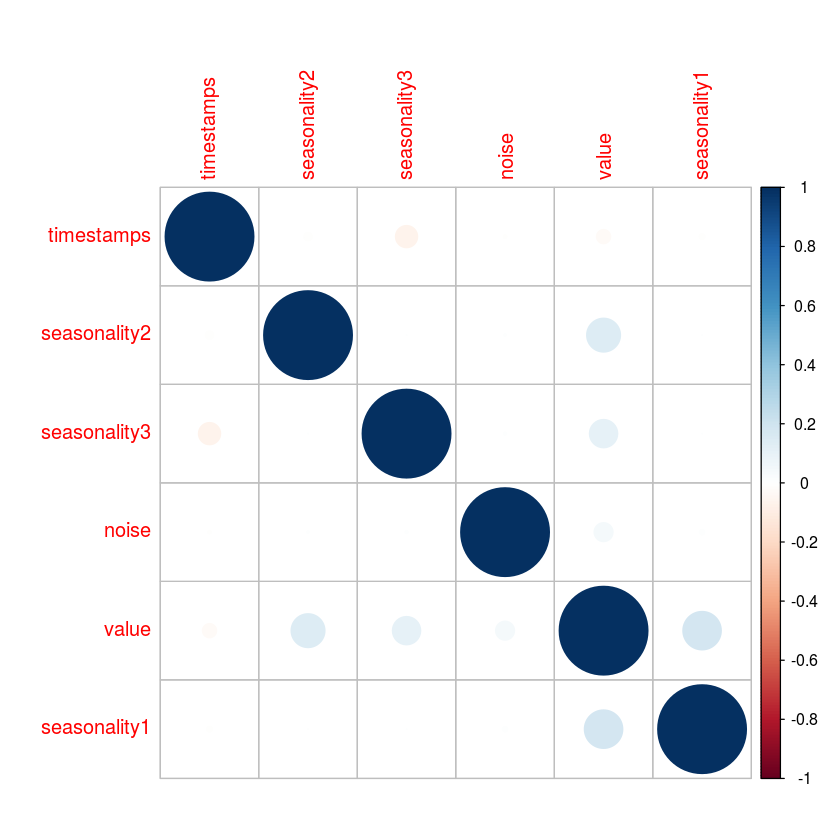

In [46]:
correlations <- cor(x_trans)
correlations[1:6, 1:6]
library(corrplot)
corrplot(correlations, order="hclust")
highCorr <- findCorrelation(correlations, cutoff = .75)
length(highCorr)

It does not appear that any of our predictors have a high correlation.

## Tools

Since we are all new to anomaly/outlier detection, we plan on taking multiple approaches to solve.  We will most likely use R and Python libraries to help is developing a solution.

## Deliverable

A confusion matrix along with key metrics such as Recall, Precision, F1-score, Balance Accuracy.  Also, graphical summary such as ROC curve and Precision-Recall Plot. 